## Attachment 3: MAVE-NN

The reviewers requested that we use the MAVE-NN package to interpret out FACS-NGS scores, instead of presenting a statistical analysis of the active kinase variants as a group. Any analysis is based on the following evidence derived from the FACS-NGS process: each variant has a genotype, phenotype, the distribution across FACS bins and the associated NGS read distribution, such that each step in the process is both a direct reflection of the previous steps and influenced by the noise in the process.

The ambition of MAVE-NN is to work backwards: 1) inferring phenotypes from the NGS distribution, then 2) interpreting the genotype-phenotype map to distinguish between global and local effects.

In order to take advantage of this process, the training set for MAVE-NN has to include active variants, inactive variants and everything in-between. Here, the trial MAVE-NN dataset is constructed with 386K variants that have at least 10 reads across the three gates. The emphasis is not on the exact set of variants to include (the borderlines are from the low set anyway), but on obtaining a valid estimation of variant phenotypes from the NGS data.

In [1]:
import sys
import os
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logomaker

import mavenn

os.chdir("/mnt/c/Users/Maya/Documents/03_Kinases/")

Matplotlib is building the font cache; this may take a moment.


In [109]:
import warnings
warnings.filterwarnings("ignore")

First, the SpliMLiB dataset is imported and the header displayed to check formatting and columns names.

In [2]:
with open('splimlib_mave.pickle', 'rb') as f:
    df_sml = pickle.load(f)

In [3]:
df_sml.head()

,mutations,ct_2,ct_1,ct_0,sequences
0,6L/7aI/8aA/9L/11F/13M,1185.0,33.0,6.0,LIALFM
1,6F/7aP/9W/11L/13M,903.0,81.0,15.0,FPΔWLM
2,6L/7aF/9L/11I/13I,899.0,2.0,8.0,LFΔLII
3,6A/7aI/8aA/9L/11L/13I,893.0,3.0,19.0,AIALLI
4,6W/7aI/9F/11L/13V,880.0,34.0,20.0,WIΔFLV


The column headers are as follows:
- mutation: each variant listing the mutation from WT caMKK1. Note that changes at positions 7a and 8a are listed only if there is an insertion present.
- ct_2: count of sequencing reads in the high gate
- ct_1: sequencing reads in medium gate
- ct_0: sequencing reads in low gate
- sequences: the amino acid resides in the six randomised positions, without intervening constant residues.

This format is compatible with MAVE-NN.

Next, generate some descriptive statistics of this dataset.

In [4]:
df_sml.describe()

,ct_2,ct_1,ct_0
count,386031.000000,386031.000000,386031.000000
mean,12.008556,7.701433,15.616425
std,45.869569,12.625967,8.688312
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,10.000000
50%,0.000000,1.000000,14.000000
75%,0.000000,12.000000,20.000000
max,1185.000000,165.000000,95.000000


The signal from the NGS is normalised to convert into percentage of reads in each of the three NGS gates: these are now listed in columns 'high', 'med' and 'low'.

In [5]:
df_per = df_sml
df_per[['high', 'med', 'low']] = df_sml[['ct_2', 'ct_1', 'ct_0']].div(df_sml[['ct_2', 'ct_1', 'ct_0']].sum(axis=1), axis=0).mul(100).round(3)
df_per.head()

,mutations,ct_2,ct_1,ct_0,sequences,high,med,low
0,6L/7aI/8aA/9L/11F/13M,1185.0,33.0,6.0,LIALFM,96.814,2.696,0.490
1,6F/7aP/9W/11L/13M,903.0,81.0,15.0,FPΔWLM,90.390,8.108,1.502
2,6L/7aF/9L/11I/13I,899.0,2.0,8.0,LFΔLII,98.900,0.220,0.880
3,6A/7aI/8aA/9L/11L/13I,893.0,3.0,19.0,AIALLI,97.596,0.328,2.077
4,6W/7aI/9F/11L/13V,880.0,34.0,20.0,WIΔFLV,94.218,3.640,2.141


In our hands attempts at getting a sensible result from the MAVE-NN were unsuccessful with random sampling of this large set of variants, whether using NGS counts or the percentage distribution between bins. We suspect the likely reason for this failure is that the full dataset is strongly biased towards low-activity variants (as most mutants are compromised in their function and were sorted in the low gate) - consequently all models just allocate all variants to a low-activity phenotype. A realistic model should instead predict that the numerically estimated latent phenotype is very negative for low gate sequences, rising for variants abundant in the high gate.

To remedy this situation, we constructed a stratified training set, which creates unequal test-train splits in three different sections. Here, it is not truly important where the boundaries between the groups are (certainly the "high" group is fairly permissive), but that the relative group sizes are approximately balanced. Specifically:

- high (high > 25): place 80% in training set 
- mostly medium (high < 25, med: place 10% in training set 
- very low (high < 1, med < 10): place 5% in training set
- everything else: place 10% in training set

In [6]:
print('High: ', df_sml.loc[df_sml['high'] > 25].count().sequences) # highest

High:  38820


In [7]:
print('Low to medium: ', df_sml.loc[(df_sml['high'] <= 25) & (df_sml['med'] >=10)].count().sequences) # low to medium

Low to medium:  143504


In [8]:
print('Very low: ', df_sml.loc[(df_sml['high'] < 1) & (df_sml['med'] < 10)].count().sequences ) # very low

Very low:  182457


In [9]:
df_sml['stratify'] = 0 # assign everything to group 0 first, just to make sure nothing is without an assignemnt
df_sml.loc[df_sml['high'] > 25, 'stratify'] = 1 # high
df_sml.loc[(df_sml['high'] <= 25) & (df_sml['med'] >=10), 'stratify'] = 2
df_sml.loc[(df_sml['high'] < 1) & (df_sml['med'] < 10), 'stratify'] = 3
df_sml.loc[(df_sml['high'] >=1) & (df_sml['high'] <= 25) & (df_sml['med'] < 10), 'stratify'] = 4

In [10]:
data_df = df_sml
# Assign to training and test sets
N = len(data_df)
np.random.seed(2000)
r = np.random.rand(N) # get an array of N random numbers between 0 and 1, uniform distribution
data_df['set'] = 'test'

Checking that the final constructed dataset makes sense:

In [11]:
data_df

,mutations,ct_2,ct_1,ct_0,sequences,high,med,low,stratify,set
0,6L/7aI/8aA/9L/11F/13M,1185.0,33.0,6.0,LIALFM,96.814,2.696,0.490,1,test
1,6F/7aP/9W/11L/13M,903.0,81.0,15.0,FPΔWLM,90.390,8.108,1.502,1,test
2,6L/7aF/9L/11I/13I,899.0,2.0,8.0,LFΔLII,98.900,0.220,0.880,1,test
3,6A/7aI/8aA/9L/11L/13I,893.0,3.0,19.0,AIALLI,97.596,0.328,2.077,1,test
4,6W/7aI/9F/11L/13V,880.0,34.0,20.0,WIΔFLV,94.218,3.640,2.141,1,test
...,...,...,...,...,...,...,...,...,...,...
386026,6P/7aL/9P/11G/13K,0.0,0.0,10.0,PLΔPGK,0.000,0.000,100.000,3,test
386027,6M/7aV/8aA/9Y/11P/13W,0.0,0.0,10.0,MVAYPW,0.000,0.000,100.000,3,test
386028,6L/7aW/9Y/11I/13G,0.0,0.0,10.0,LWΔYIG,0.000,0.000,100.000,3,test
386029,6G/7aP/8aA/9G/11Y/13V,0.0,0.0,10.0,GPAGYV,0.000,0.000,100.000,3,test


Next, we set up the data in a format fitting with the MAVE-NN package, following the original code and adjusting for the measurement-agnostic process (which has little documentation yet). The test and train set are constant for all variation of the G-P map.

In [12]:
test_fractions = {1: 0.2, 2: 0.9, 3: 0.95, 4: 0.9}

for k, v in test_fractions.items():
    test_frac = v # first split of test fraction
    ix_train = (test_frac  <= r) & (data_df['stratify'] == k) 
    ix_test = (r < test_frac) & (data_df['stratify'] == k)
    data_df.loc[ix_train, 'set'] = 'training'
    data_df.loc[ix_test, 'set'] = 'test'

In [13]:
# Split into training and test data
ix = (data_df['set'] == 'training')
train_df = data_df[ix]
test_df = data_df[~ix]

# Extract x and y as np.arrays
x_train = train_df['sequences'].values
y_train = train_df[['high', 'med', 'low']].values
x_test = test_df['sequences'].values
y_test = test_df[['high', 'med', 'low']].values

In [14]:
L = len(data_df['sequences'][0])
y_cols = data_df.columns[5:8]
Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=6, Y=3


In [15]:
# Show dataset sizes
print(f'Training set size: {len(x_train):6,d} observations')
print(f'Test set size    : {len(x_test):6,d} observations')

Training set size: 56,591 observations
Test set size    : 329,440 observations


### Comparison of measurement process graphs

Reviewer: A good way to measure the performance of MAVE-NN is to plot the distribution across bins for all possible latent phenotypic value. The authors did make this plot for all three models they fitted. However, I note that the plot ranges in the p(y | phi) vs. latent phenotype figures for the three models are all -5 to +3. I think it is very unlikely that the three models all happened to have the exact same range for their latent phenotypes. And since this plot range is the same as this example (https://github.com/jbkinney/mavenn/blob/master/mavenn/examples/tutorials/sortseq_mpa_visualization.png), I think it is probable that the authors used the same arbitrary plot range for all three methods. The actual dynamic range for the latent phenotype could be much wider than what is shown. This can explain why the distribution among bins are so uniform across the plotted range, since the plots only show the middle region of the phenotypic distribution. So I suggest the authors remake these figures using the actual range of phi.


Following reviewer suggestion above (1), extract the relevant Phi values from three models: additive, neighbour and pairwise.

In [64]:
m_additive = mavenn.load('splimlib_mpa_additive')
m_neighbour = mavenn.load('splimlib_mpa_neighbour')
m_pairwise = mavenn.load('splimlib_mpa_pairwise')
models = [m_additive, m_neighbour, m_pairwise]

titles = ['additive', 'neighbour', 'pairwise']

Model loaded from these files:
	splimlib_mpa_additive.pickle
	splimlib_mpa_additive.h5
Model loaded from these files:
	splimlib_mpa_neighbour.pickle
	splimlib_mpa_neighbour.h5
Model loaded from these files:
	splimlib_mpa_pairwise.pickle
	splimlib_mpa_pairwise.h5


In [67]:
x = data_df['sequences'].values
# Create array of allowable y values
# Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

In [73]:
# calculate phi_pairwise in advance, as it takes a long time
phi_pairs = [model.x_to_phi(x) for model in models]

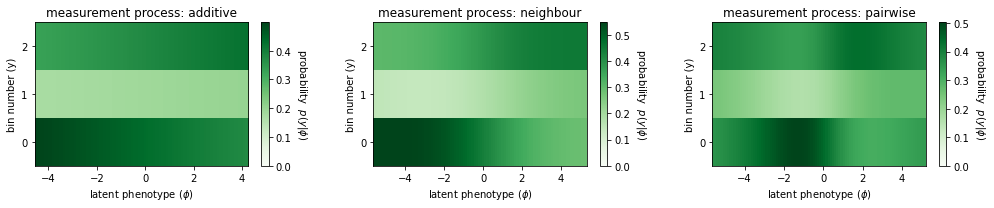

In [77]:
# Create figure with three panels
fig, axes = plt.subplots(1,len(models),figsize=[14,3])

for i in range(len(models)):
    model = models[i]

    # Create grid in phi space
    phi_pairwise = phi_pairs[i]
    phi_lim = [np.amin(phi_pairwise), np.amax(phi_pairwise)]
    phi_grid = np.linspace(phi_lim[0], phi_lim[1], 100)
    
    # Compute matrix of p(y|phi) values
    measurement_process = model.p_of_y_given_phi(y_all, phi_grid)

    # left panel: draw measurement process as heatmap
    ax = axes[i]
    im = ax.imshow(measurement_process,
                   cmap='Greens',
                   extent=phi_lim+y_lim,
                   vmin=0,
                   origin='lower',
                   interpolation='nearest',
                   aspect="auto")
    ax.set_yticks(y_all)
    ax.set_ylabel('bin number (y)')
    ax.set_xlabel('latent phenotype ($\phi$)')
    ax.set_title('measurement process: ' + titles[i])
    cb = plt.colorbar(im, ax=ax)
    cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

fig.tight_layout(w_pad=3)
plt.show()

Having remade the plots, the actual range is closer to -5 to 5, varying slightly by the type of MAVE model. The improved plot window adds clarity to the plot, but does not change the overall observation: that something is wrong with the pairwise model.

### Construct single position and pairwise heatmaps for each model

(2) I think the authors have not provided enough output to examine the effect of single and double mutants. For all three models, the authors only provided sequence logos for the single mutant effects. While this is one way to visualize single mutational effects, the sequence logo is not very readable. And this makes it hard to compare the MAVE-NN results with the results in the paper which is presented in a position weight matrix. More importantly, for the two epistatic models, there should be a heat map showing the pairwise interaction strengths, similar to figure 4 in the manuscript. I believe there are helper methods in MAVE-NN that can automatically generate the heat map for both the single mutant and double mutant effects. Therefore, I suggest the authors make these figures and compare them with their existing results, for example by making a scatter plot and examine the R^2

In [95]:
sml_alphabet = np.array(['A','G','P','Y','D','K','M','V','I','L','F','W','Δ'])
wt = 'PΔΔILP'

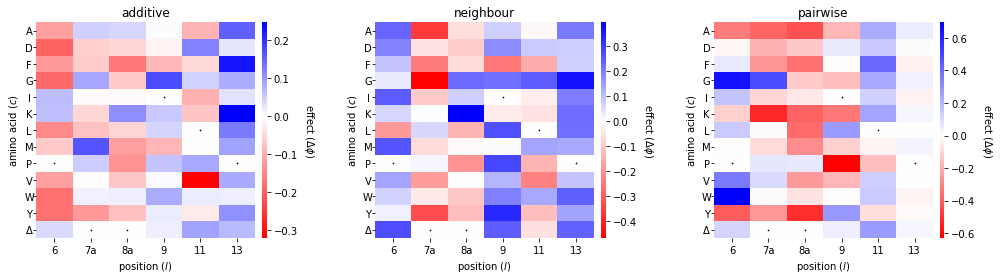

In [110]:

# Create figure with three panels
fig, axes = plt.subplots(1,len(models),figsize=[14,4])

for i in range(len(models)):
    model = models[i]
    ax = axes[i]
    # Get effects of all single-point mutations on phi
    theta_dict = model.get_theta(gauge='user', x_wt=wt)
    # draw heatmap illustrating 1pt mutation effects
    ax, cb = mavenn.heatmap(theta_dict['theta_lc'],
                            alphabet=theta_dict['alphabet'],
                            seq=x_wt,
                            ax=ax,
                            cmap='bwr_r',
                            ccenter=0,
                            cmap_size='2%')
    ax.set_xticklabels(['0','6', '7a', '8a', '9', '11', '13'])
    ax.set_xlabel('position ($l$)')
    ax.set_ylabel('amino acid ($c$)')
    ax.set_title(titles[i])
    cb.set_label('effect ($\Delta\phi$)', rotation=-90, va="bottom")
    cb.outline.set_visible(False)

fig.tight_layout(w_pad=3)
plt.show()

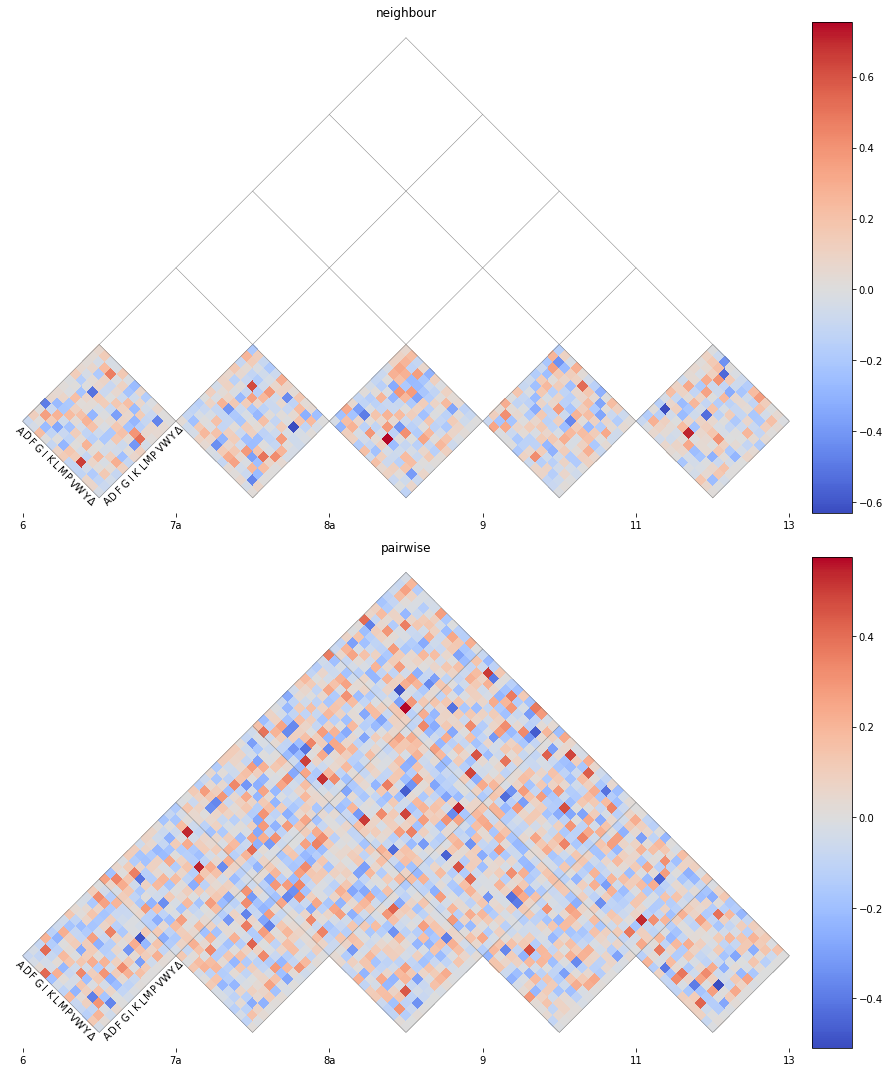

In [116]:
fig, axes = plt.subplots(2, 1, figsize=[32, 15])
for i in [1,2]:
    ax = axes[i-1]
    theta = models[i].get_theta()

    ax, cb = mavenn.heatmap_pairwise(values=theta['theta_lclc'],
                            alphabet=theta['alphabet'],
                            ax=ax)
    ax.set_xticklabels(['6', '7a', '8a', '9', '11', '13'])
    ax.set_title(titles[i])

plt.tight_layout()
plt.show()

The single and pairwise heatmaps show that the models, as currently trained, don't meaningfully describe the D-domain fitness landscape.